### GradientBoosting and Neural Network

In [1]:
# import packages 

import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn import ensemble, metrics

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

# time
import time

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load dataset 

df = pd.read_csv("cleanedData.csv")
df.head(10)

,ID,IUCR,Location Description,Arrest,Domestic,Beat,District,FBI Code,Year,Date,Time,Month,Day,DayofWeek,PRIMARY DESCRIPTION,SECONDARY DESCRIPTION,INDEX CODE
0,5223506,2825,RESIDENCE,False,True,2122,2.0,26,2007,2007-01-03,10:00:00,Jan,3,Wednesday,OTHER OFFENSE,HARASSMENT BY TELEPHONE,N
1,5224416,1320,STREET,False,False,1323,12.0,14,2007,2007-01-04,18:00:00,Jan,4,Thursday,CRIMINAL DAMAGE,TO VEHICLE,N
2,5224520,5002,STREET,True,False,111,1.0,26,2007,2007-01-05,09:30:00,Jan,5,Friday,OTHER OFFENSE,OTHER VEHICLE OFFENSE,N
3,5225556,1320,STREET,False,False,111,1.0,14,2007,2007-01-05,19:00:00,Jan,5,Friday,CRIMINAL DAMAGE,TO VEHICLE,N
4,5227933,2024,STREET,True,False,2323,19.0,18,2007,2007-01-04,14:50:00,Jan,4,Thursday,NARCOTICS,POSS: HEROIN(WHITE),N
5,5227797,2094,SIDEWALK,True,False,1532,15.0,18,2007,2007-01-05,11:35:00,Jan,5,Friday,NARCOTICS,ATTEMPT POSSESSION CANNABIS,N
6,5242118,1811,STREET,True,False,2422,24.0,18,2007,2007-01-07,13:00:00,Jan,7,Sunday,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,N
7,5242417,0460,SIDEWALK,False,False,726,7.0,08B,2007,2007-01-13,01:39:10,Jan,13,Saturday,BATTERY,SIMPLE,U
8,5243014,0460,FACTORY/MANUFACTURING BUILDING,False,False,925,9.0,08B,2007,2007-01-13,09:00:00,Jan,13,Saturday,BATTERY,SIMPLE,U
9,5243687,0850,FACTORY/MANUFACTURING BUILDING,False,False,925,9.0,06,2007,2007-01-14,02:50:16,Jan,14,Sunday,THEFT,ATTEMPT THEFT,U


In [3]:
df.dtypes
hours = pd.to_datetime(df['Time']).dt.hour
hours.head(10)


0    10
1    18
2     9
3    19
4    14
5    11
6    13
7     1
8     9
9     2
Name: Time, dtype: int64

In [4]:
loca  = df['Location Description']
loca.unique().tolist()

['RESIDENCE',
 'STREET',
 'SIDEWALK',
 'FACTORY/MANUFACTURING BUILDING',
 'PARKING LOT/GARAGE(NON.RESID.)',
 'GAS STATION',
 'RESIDENCE-GARAGE',
 'CHA PARKING LOT/GROUNDS',
 'RESTAURANT',
 'NURSING HOME/RETIREMENT HOME',
 'OTHER',
 'VACANT LOT/LAND',
 'GROCERY FOOD STORE',
 'CONSTRUCTION SITE',
 'SCHOOL, PRIVATE, BUILDING',
 'CLEANING STORE',
 'WAREHOUSE',
 'APARTMENT',
 'ALLEY',
 'COMMERCIAL / BUSINESS OFFICE',
 'HOTEL/MOTEL',
 'DRIVEWAY - RESIDENTIAL',
 'BAR OR TAVERN',
 'RESIDENCE PORCH/HALLWAY',
 'CTA TRAIN',
 'VEHICLE NON-COMMERCIAL',
 'RESIDENTIAL YARD (FRONT/BACK)',
 'SMALL RETAIL STORE',
 'ATHLETIC CLUB',
 'TAVERN/LIQUOR STORE',
 'CONVENIENCE STORE',
 'GOVERNMENT BUILDING/PROPERTY',
 'HOSPITAL BUILDING/GROUNDS',
 'DEPARTMENT STORE',
 'OTHER COMMERCIAL TRANSPORTATION',
 'CHA HALLWAY/STAIRWELL/ELEVATOR',
 'CHA APARTMENT',
 'DRUG STORE',
 'BARBERSHOP',
 'SCHOOL, PUBLIC, BUILDING',
 'CTA BUS',
 'TAXICAB',
 'VEHICLE-COMMERCIAL',
 'PARK PROPERTY',
 'POLICE FACILITY/VEH PARKING LOT',


In [5]:
newDf = df.copy()

# its hard to build a model that predicts the type of a crime location
# in 157 categories, therefore, we separate these location types into fewer categories 
# 1. Residential Area, 2.Public Open Space, 3. Non-Resid Buildings 4. Transporatation, 0.OTHER
newDf.loc[:, 'Loca Num'] = np.where( loca.str.contains('RESIDEN')
                                    |loca.str.contains('APARTMENT'), 1,
                                    np.where(loca.str.contains('STREET')
                                             |loca.str.contains('SIDEWALK')
                                             |loca.str.contains('STATION')
                                             |loca.str.contains('LOT')
                                             |loca.str.contains('ALLEY')
                                             |loca.str.contains('PLATFORM')
                                             |loca.str.contains('HIGHWAY')
                                             |loca.str.contains('BRIDGE')
                                             |loca.str.contains('LAKEFRONT')
                                             |loca.str.contains('FOREST')
                                             |loca.str.contains('LAKE')
                                             |loca.str.contains('RIVER')
                                             |loca.str.contains('PARK'), 2,
                                             np.where(loca.str.contains('BUILDING')
                                                      |loca.str.contains('STORE')
                                                      |loca.str.contains('RESTAURANT')
                                                      |loca.str.contains('SCHOOL')
                                                      |loca.str.contains('OFFICE')
                                                      |loca.str.contains('HOTEL')
                                                      |loca.str.contains('BANK')
                                                      |loca.str.contains('CONSTRUCTION SITE')
                                                      |loca.str.contains('CLUB')
                                                      |loca.str.contains('BARBERSHOP')
                                                      |loca.str.contains('COLLEGE')
                                                      |loca.str.contains('LIBRARY')
                                                      |loca.str.contains('ATM')
                                                      |loca.str.contains('CENTER')
                                                      |loca.str.contains('THEATER')
                                                      |loca.str.contains('CHURCH')
                                                      |loca.str.contains('STADIUM')
                                                      |loca.str.contains('FACILITY')
                                                      |loca.str.contains('SHOP')
                                                      |loca.str.contains('HOSPITAL')
                                                      |loca.str.contains('CREDIT UNION')
                                                      |loca.str.contains('MOTEL')
                                                      |loca.str.contains('AIRPORT')
                                                      |loca.str.contains('FACTORY')
                                                      |loca.str.contains('ROOM')
                                                      |loca.str.contains('BAR'), 3,
                                                      np.where( loca.str.contains('TRANSPORTATION')
                                                                |loca.str.contains('TRUCK')
                                                                |loca.str.contains('BUS')
                                                                |loca.str.contains('TAXICAB')
                                                                |loca.str.contains('VEHICLE')
                                                                |loca.str.contains('TRAIN'), 4,
                                                                0))))
                                                               

In [6]:
# Label Encoding categorical data 
newDf.drop(['ID', 'Time', 'Location Description'], axis = 1, inplace = True)
newDf['Hours'] = hours

# all categorical data
categories = ['IUCR','Arrest',
           'FBI Code', 'Domestic', 'Month', 'DayofWeek',
           'PRIMARY DESCRIPTION', 'SECONDARY DESCRIPTION', 'INDEX CODE', 'Hours']
encoders = {}

for i in categories:
    # Create a label (category) encoder object
    encoders[i] = preprocessing.LabelEncoder()

    # Fit the encoder to the pandas column
    encoders[i].fit(newDf[i])
    
    # View the labels (if you want)
    #list(le.classes_)
    
    # Apply the fitted encoder to the pandas column
    trans = encoders[i].transform(newDf[i]) 
    
    # Append to DataFrame
    newName = i + '_encoded'
    newDf.loc[:, newName] = pd.Series(trans, index = newDf.index)

newDf.describe()

,Beat,District,Year,Day,Loca Num,Hours,IUCR_encoded,Arrest_encoded,FBI Code_encoded,Domestic_encoded,Month_encoded,DayofWeek_encoded,PRIMARY DESCRIPTION_encoded,SECONDARY DESCRIPTION_encoded,INDEX CODE_encoded,Hours_encoded
count,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06
mean,1.181222e+03,1.130010e+01,2.010991e+03,1.564463e+01,1.765142e+00,1.315196e+01,1.257202e+02,2.700856e-01,1.211051e+01,1.383998e-01,5.576326e+00,2.982576e+00,1.423277e+01,2.029977e+02,1.553849e+00,1.315196e+01
std,7.002026e+02,6.926531e+00,2.841988e+00,8.829594e+00,8.529346e-01,6.717154e+00,8.506388e+01,4.440039e-01,6.568510e+00,3.453191e-01,3.460171e+00,2.019707e+00,1.124264e+01,1.090440e+02,5.534576e-01,6.717154e+00
min,1.110000e+02,1.000000e+00,2.007000e+03,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.210000e+02,6.000000e+00,2.008000e+03,8.000000e+00,1.000000e+00,9.000000e+00,7.600000e+01,0.000000e+00,7.000000e+00,0.000000e+00,3.000000e+00,1.000000e+00,3.000000e+00,1.300000e+02,1.000000e+00,9.000000e+00
50%,1.032000e+03,1.000000e+01,2.011000e+03,1.600000e+01,2.000000e+00,1.400000e+01,9.400000e+01,0.000000e+00,1.000000e+01,0.000000e+00,6.000000e+00,3.000000e+00,1.600000e+01,2.420000e+02,2.000000e+00,1.400000e+01
75%,1.723000e+03,1.700000e+01,2.013000e+03,2.300000e+01,2.000000e+00,1.900000e+01,1.550000e+02,1.000000e+00,1.600000e+01,0.000000e+00,9.000000e+00,5.000000e+00,2.700000e+01,3.010000e+02,2.000000e+00,1.900000e+01
max,2.535000e+03,3.100000e+01,2.016000e+03,3.100000e+01,4.000000e+00,2.300000e+01,3.850000e+02,1.000000e+00,2.500000e+01,1.000000e+00,1.100000e+01,6.000000e+00,3.100000e+01,3.630000e+02,2.000000e+00,2.300000e+01


,Arrest,Domestic,Beat,District,Year,Day,Loca Num,Hours,IUCR_encoded,Arrest_encoded,FBI Code_encoded,Domestic_encoded,Month_encoded,DayofWeek_encoded,PRIMARY DESCRIPTION_encoded,SECONDARY DESCRIPTION_encoded,INDEX CODE_encoded,Hours_encoded
Arrest,1.000000,-0.067204,-0.022398,-0.019107,-0.032576,-0.000739,0.139463,0.088836,0.360453,1.000000,0.389525,-0.067204,-0.006164,0.013254,0.023093,0.195666,-0.245216,0.088836
Domestic,-0.067204,1.000000,-0.043635,-0.041463,0.039201,-0.000403,-0.224316,-0.032560,-0.092023,-0.067204,0.014134,1.000000,-0.007389,-0.008226,-0.260474,-0.117564,0.126900,-0.032560
Beat,-0.022398,-0.043635,1.000000,0.955455,-0.032835,-0.001028,0.020929,-0.012246,0.004587,-0.022398,-0.008005,-0.043635,0.000413,-0.007906,0.039693,-0.001622,0.021951,-0.012246
District,-0.019107,-0.041463,0.955455,1.000000,-0.003835,-0.000951,0.019623,-0.012674,0.005900,-0.019107,-0.006370,-0.041463,0.000737,-0.008135,0.035361,-0.001012,0.018611,-0.012674
Year,-0.032576,0.039201,-0.032835,-0.003835,1.000000,0.001093,-0.001456,0.006844,-0.032584,-0.032576,-0.033159,0.039201,-0.004227,-0.003604,0.009906,-0.046992,0.012712,0.006844
Day,-0.000739,-0.000403,-0.001028,-0.000951,0.001093,1.000000,0.008839,0.016261,-0.009353,-0.000739,-0.008404,-0.000403,0.003395,-0.000335,-0.004819,0.002312,0.005476,0.016261
Loca Num,0.139463,-0.224316,0.020929,0.019623,-0.001456,0.008839,1.000000,0.040782,-0.011573,0.139463,-0.041395,-0.224316,0.008215,0.004239,0.189780,0.038849,0.005214,0.040782
Hours,0.088836,-0.032560,-0.012246,-0.012674,0.006844,0.016261,0.040782,1.000000,0.060034,0.088836,0.060187,-0.032560,0.002139,0.008238,0.030308,0.049960,-0.031730,1.000000
IUCR_encoded,0.360453,-0.092023,0.004587,0.005900,-0.032584,-0.009353,-0.011573,0.060034,1.000000,0.360453,0.866689,-0.092023,-0.010969,0.009607,0.203480,0.305674,-0.616860,0.060034
Arrest_encoded,1.000000,-0.067204,-0.022398,-0.019107,-0.032576,-0.000739,0.139463,0.088836,0.360453,1.000000,0.389525,-0.067204,-0.006164,0.013254,0.023093,0.195666,-0.245216,0.088836


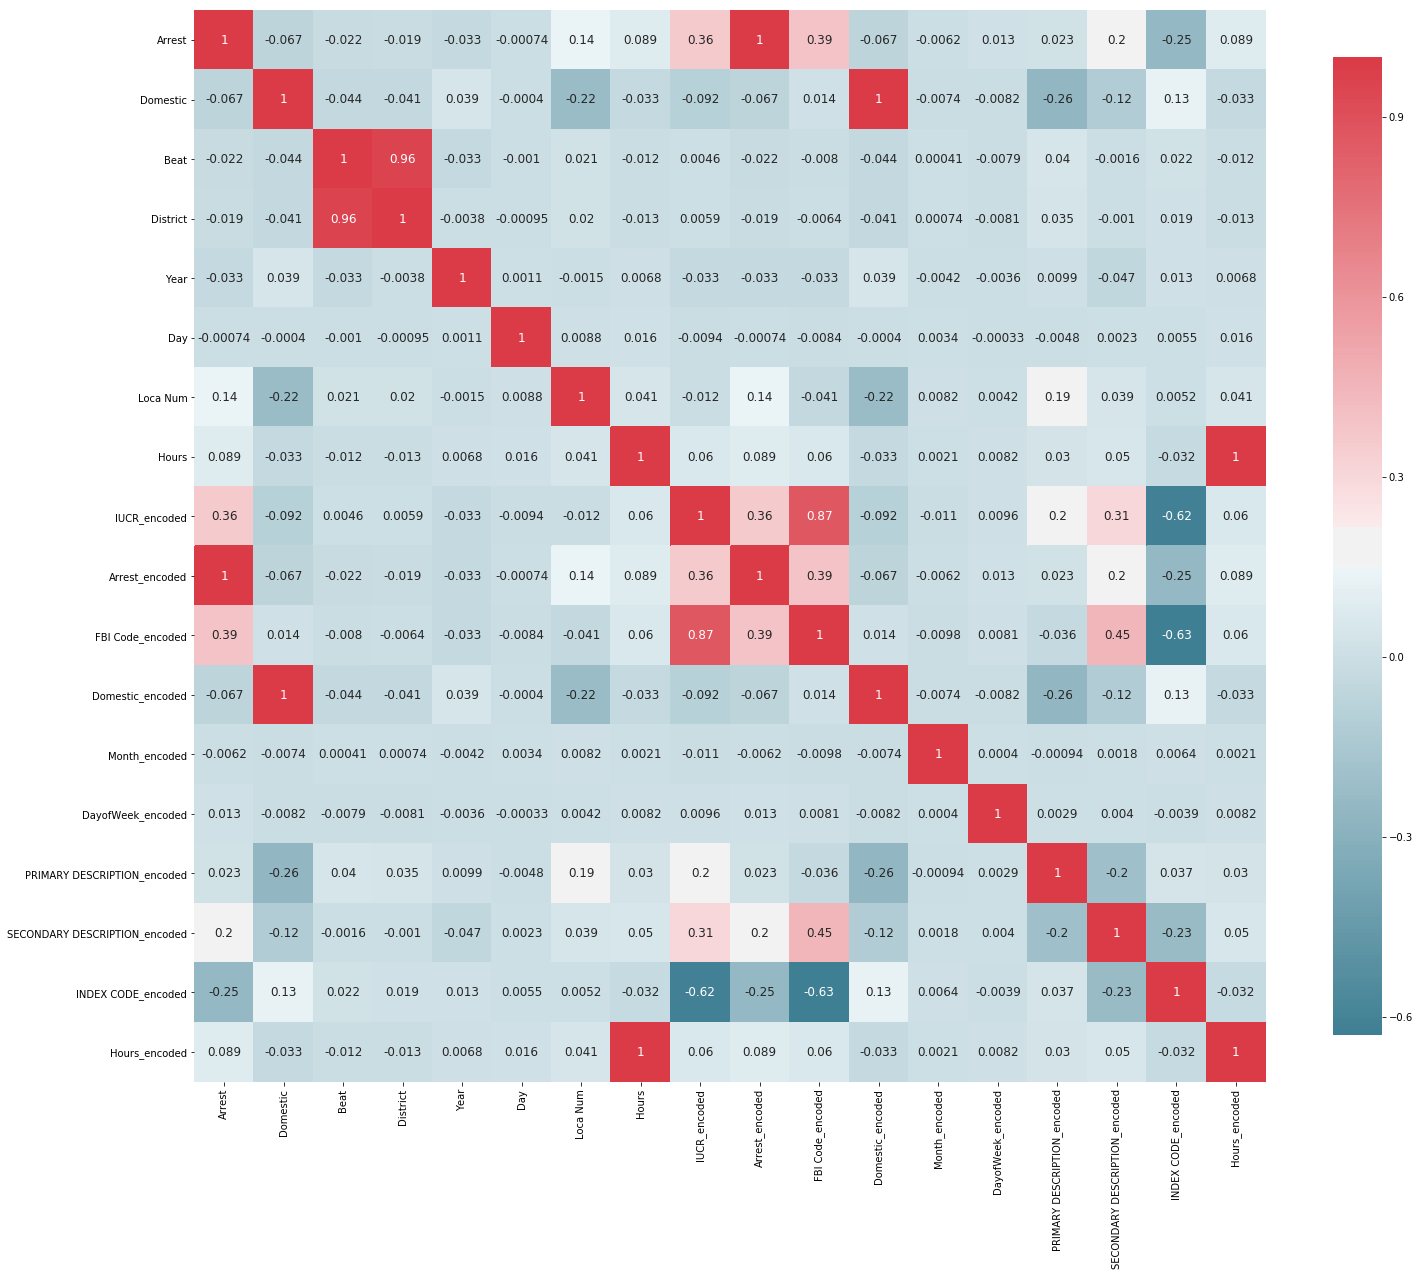

In [7]:
def plot_correlation_map(df):
    """
    This function plots the correlation map of a given dataframe
    """
    corr = df.corr()
    _ , ax = plt.subplots( figsize =(24, 20 ) )
    cmap = sns.diverging_palette(220, 10, as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )


plot_correlation_map(newDf)
newDf.corr()

In [8]:
# MODEL FEATURES: TIME, LOCATION, determine TYPE 
location = newDf['Loca Num']
train1 = newDf[['Month_encoded', 'DayofWeek_encoded',
           'PRIMARY DESCRIPTION_encoded', 'Hours', 'District']]


# split our data into train and test
x_train , x_test , y_train , y_test = train_test_split(train1 , location , test_size = 0.30,random_state =2)

In [9]:
# confusion matrix 
# https://towardsdatascience.com/demystifying-confusion-matrix-confusion-9e82201592fd

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [39]:
# The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting 
# so a large number usually results in better performance.

# count time building the model 
time_start = time.clock()

gbr = ensemble.GradientBoostingRegressor(n_estimators = 15, max_depth = 5,
                                         loss = 'ls')

gbr.fit(x_train, y_train)
gbr_pred = gbr.predict(x_test)
gbr_comparison = pd.crosstab(y_test, gbr_pred)

grd_time = (time.clock() - time_start)

print("time to build a Gradient Boosting Model is:", grd_time)
print("Test Accuracy: ", metrics.accuracy_score(y_test, gbr_pred.round()))

time to build a Gradient Boosting Model is: 88.8652230000007
Test Accuracy:  0.5173005377542844


In [47]:
# The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting 
# so a large number usually results in better performance.

# count time building the model 
time_start = time.clock()

gbr2 = ensemble.GradientBoostingRegressor(n_estimators = 35, max_depth = 5,
                                         loss = 'ls')

gbr2.fit(x_train, y_train)

gbr_pred2 = gbr2.predict(x_test)
gbr_comparison2 = pd.crosstab(y_test, gbr_pred2)

grd_time2 = (time.clock() - time_start)
print("time to build a Gradient Boosting Model is:", grd_time2)
print("Test Accuracy: ", metrics.accuracy_score(y_test, gbr_pred2.round()))

time to build a Gradient Boosting Model is: 207.81080199999997
Test Accuracy:  0.5252105790473482


In [46]:
# The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting 
# so a large number usually results in better performance.

# count time building the model 
time_start = time.clock()

gbr3 = ensemble.GradientBoostingRegressor(n_estimators = 50, max_depth = 5,
                                         loss = 'ls')

gbr3.fit(x_train, y_train)

gbr_pred3 = gbr3.predict(x_test)
gbr_comparison3 = pd.crosstab(y_test, gbr_pred3)

grd_time3 = (time.clock() - time_start)
print("time to build a Gradient Boosting Model is:", grd_time3)
print("Test Accuracy: ", metrics.accuracy_score(y_test, gbr_pred3.round()))

time to build a Gradient Boosting Model is: 287.8287249999994
Test Accuracy:  0.5297965335636372


In [54]:
# The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting 
# so a large number usually results in better performance.

# count time building the model 
time_start = time.clock()

gbr4 = ensemble.GradientBoostingRegressor(n_estimators = 15, max_depth = 10,
                                         loss = 'ls')

gbr4.fit(x_train, y_train)
gbr_pred4 = gbr4.predict(x_test)
gbr_comparison4 = pd.crosstab(y_test, gbr_pred)

grd_time4 = (time.clock() - time_start)

print("time to build a Gradient Boosting Model is:", grd_time4)
print("Test Accuracy: ", metrics.accuracy_score(y_test, gbr_pred4.round()))

time to build a Gradient Boosting Model is: 1119.4728370000012
Test Accuracy:  0.5258931170762057


#### N_tree = 50, max_depth=5

In [48]:
report =  metrics.classification_report(y_test, gbr_pred3.round())
print(report)

             precision    recall  f1-score   support

          0       0.00      0.00      0.00     48043
          1       0.72      0.32      0.44    349275
          2       0.50      0.95      0.65    455281
          3       0.64      0.02      0.03    144915
          4       0.00      0.00      0.00     29535

avg / total       0.56      0.53      0.44   1027049



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix, without normalization
[[     0   6341  41391    311      0]
 [     0 110574 238607     94      0]
 [     0  23309 431320    652      0]
 [     0  10662 132020   2233      0]
 [     0   1717  27598    220      0]]


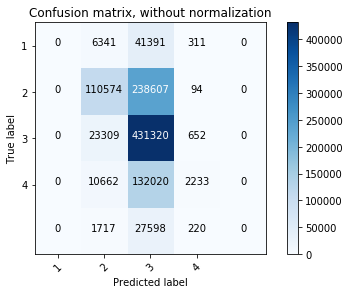

In [49]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, gbr_pred3.round())
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4],
                      title='Confusion matrix, without normalization')
plt.savefig('gbr_cm_wo_normal.png')
plt.show()

Normalized confusion matrix
[[0.   0.13 0.86 0.01 0.  ]
 [0.   0.32 0.68 0.   0.  ]
 [0.   0.05 0.95 0.   0.  ]
 [0.   0.07 0.91 0.01 0.  ]
 [0.   0.06 0.93 0.01 0.  ]]


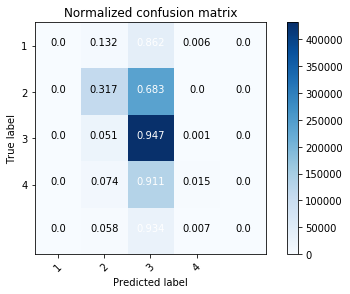

In [50]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4], normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('gbr_cm_w_normal.png')
plt.show()

### neural network

In [55]:
# https://towardsdatascience.com/deep-learning-for-beginners-practical-guide-with-python-and-keras-d295bfca4487


y_train2 = to_categorical(y_train, num_classes=5)
y_test2 = to_categorical(y_test, num_classes=5)

# count time building the model 
time_start = time.clock()

nn = Sequential()
nn.add(Dense(128, input_dim=5, activation='tanh'))
nn.add(Dense(128, activation='tanh'))
nn.add(Dense(128, activation='tanh'))
nn.add(Dense(128, activation='tanh'))
nn.add(Dense(5, activation='softmax'))
nn.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

nn.fit(x_train, y_train2, batch_size=128, epochs=5)

nn_pred = nn.predict_classes(x_test)

nn_time = (time.clock() - time_start)
print("time to build a Neural Network Model is:", nn_time)
print("Test Accuracy: ", metrics.accuracy_score(y_test, nn_pred))

Epoch 1/5
2396447/2396447 [==============================] - 182s 76us/step - loss: 1.1486 - acc: 0.5160
Epoch 2/5
2396447/2396447 [==============================] - 168s 70us/step - loss: 1.1230 - acc: 0.5247
Epoch 3/5
2396447/2396447 [==============================] - 180s 75us/step - loss: 1.0995 - acc: 0.5374
Epoch 4/5
2396447/2396447 [==============================] - 175s 73us/step - loss: 1.0787 - acc: 0.5531
Epoch 5/5
2396447/2396447 [==============================] - 188s 78us/step - loss: 1.0696 - acc: 0.5575
time to build a Neural Network Model is: 2663.3100399999967
Test Accuracy:  0.5580376398789152


In [19]:
# https://towardsdatascience.com/deep-learning-for-beginners-practical-guide-with-python-and-keras-d295bfca4487

# count time building the model 
time_start = time.clock()

nn2 = Sequential()
nn2.add(Dense(128, input_dim=5, activation='relu'))
nn2.add(Dense(128, activation='relu'))
nn2.add(Dense(128, activation='relu'))
nn2.add(Dense(128, activation='relu'))
nn2.add(Dense(5, activation='softmax'))
nn2.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

nn2.fit(x_train, y_train2, batch_size=128, epochs=5)
nn_pred2 = nn2.predict_classes(x_test)

nn_time2 = (time.clock() - time_start)
print("time to build a Neural Network Model is:", nn_time2)
print("Test Accuracy: ", metrics.accuracy_score(y_test, nn_pred2))

Epoch 1/5
2396447/2396447 [==============================] - 121s 51us/step - loss: 1.1513 - acc: 0.5170
Epoch 2/5
2396447/2396447 [==============================] - 118s 49us/step - loss: 1.1117 - acc: 0.5297
Epoch 3/5
2396447/2396447 [==============================] - 111s 46us/step - loss: 1.0874 - acc: 0.5462
Epoch 4/5
2396447/2396447 [==============================] - 110s 46us/step - loss: 1.0749 - acc: 0.5552
Epoch 5/5
2396447/2396447 [==============================] - 115s 48us/step - loss: 1.0679 - acc: 0.5588
time to build a Neural Network Model is: 2089.3632699999994
Test Accuracy:  0.5648114160083891


In [21]:
# https://towardsdatascience.com/deep-learning-for-beginners-practical-guide-with-python-and-keras-d295bfca4487

# count time building the model 
time_start = time.clock()

nn3 = Sequential()
nn3.add(Dense(128, input_dim=5, activation='sigmoid'))
nn3.add(Dense(128, activation='sigmoid'))
nn3.add(Dense(128, activation='sigmoid'))
nn3.add(Dense(128, activation='sigmoid'))
nn3.add(Dense(5, activation='softmax'))
nn3.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

nn3.fit(x_train, y_train2, batch_size=128, epochs=5)
nn_pred3 = nn3.predict_classes(x_test)

nn_time3 = (time.clock() - time_start)
print("time to build a Neural Network Model is:", nn_time3)
print("Test Accuracy: ", metrics.accuracy_score(y_test, nn_pred3))

Epoch 1/5
2396447/2396447 [==============================] - 176s 74us/step - loss: 1.2323 - acc: 0.4666
Epoch 2/5
2396447/2396447 [==============================] - 176s 74us/step - loss: 1.2118 - acc: 0.5048
Epoch 3/5
2396447/2396447 [==============================] - 178s 74us/step - loss: 1.2038 - acc: 0.5063
Epoch 4/5
2396447/2396447 [==============================] - 167s 70us/step - loss: 1.1922 - acc: 0.5072
Epoch 5/5
2396447/2396447 [==============================] - 164s 69us/step - loss: 1.1812 - acc: 0.5069
time to build a Neural Network Model is: 2928.629446000001
Test Accuracy:  0.5072367530663094


In [33]:
# optimal number for nodes 
# count time building the model 
time_start = time.clock()

nn4 = Sequential()
nn4.add(Dense(64, input_dim=5, activation='relu'))
nn4.add(Dense(64, activation='relu'))
nn4.add(Dense(64, activation='relu'))
nn4.add(Dense(64, activation='relu'))
nn4.add(Dense(5, activation='softmax'))
nn4.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

nn4.fit(x_train, y_train2, batch_size=64, epochs=5)
nn_pred4 = nn4.predict_classes(x_test)

nn_time4 = (time.clock() - time_start)
print("time to build a Neural Network Model is:", nn_time4)
print("Test Accuracy: ", metrics.accuracy_score(y_test, nn_pred4))

Epoch 1/5
2396447/2396447 [==============================] - 173s 72us/step - loss: 1.1421 - acc: 0.5196
Epoch 2/5
2396447/2396447 [==============================] - 173s 72us/step - loss: 1.0960 - acc: 0.5396
Epoch 3/5
2396447/2396447 [==============================] - 162s 68us/step - loss: 1.0773 - acc: 0.5540
Epoch 4/5
2396447/2396447 [==============================] - 150s 63us/step - loss: 1.0685 - acc: 0.55840s - loss: 1.0686 - 
Epoch 5/5
2396447/2396447 [==============================] - 151s 63us/step - loss: 1.0638 - acc: 0.5600
time to build a Neural Network Model is: 2728.9202149999983
Test Accuracy:  0.5607775286281375


In [34]:
# optimal number for nodes 
# count time building the model 
time_start = time.clock()

nn5 = Sequential()
nn5.add(Dense(256, input_dim=5, activation='relu'))
nn5.add(Dense(256, activation='relu'))
nn5.add(Dense(256, activation='relu'))
nn5.add(Dense(256, activation='relu'))
nn5.add(Dense(5, activation='softmax'))
nn5.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

nn5.fit(x_train, y_train2, batch_size=256, epochs=5)
nn_pred5 = nn5.predict_classes(x_test)

nn_time5 = (time.clock() - time_start)
print("time to build a Neural Network Model is:", nn_time5)
print("Test Accuracy: ", metrics.accuracy_score(y_test, nn_pred5))

Epoch 1/5
2396447/2396447 [==============================] - 156s 65us/step - loss: 1.1621 - acc: 0.5139
Epoch 2/5
2396447/2396447 [==============================] - 162s 68us/step - loss: 1.1307 - acc: 0.5229
Epoch 3/5
2396447/2396447 [==============================] - 169s 70us/step - loss: 1.1141 - acc: 0.5287
Epoch 4/5
2396447/2396447 [==============================] - 154s 64us/step - loss: 1.0995 - acc: 0.5353
Epoch 5/5
2396447/2396447 [==============================] - 169s 71us/step - loss: 1.0873 - acc: 0.5444
time to build a Neural Network Model is: 2735.802536000003
Test Accuracy:  0.5463604949715155


In [51]:
# most efficient shape 
# increasing 

# count time building the model 
time_start = time.clock()

nn6 = Sequential()
nn6.add(Dense(64, input_dim=5, activation='relu'))
nn6.add(Dense(128, activation='relu'))
nn6.add(Dense(128, activation='relu'))
nn6.add(Dense(256, activation='relu'))
nn6.add(Dense(5, activation='softmax'))
nn6.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

nn6.fit(x_train, y_train2, batch_size=128, epochs=5)
nn_pred6 = nn6.predict_classes(x_test)

nn_time6 = (time.clock() - time_start)
print("time to build a Neural Network Model is:", nn_time6)
print("Test Accuracy: ", metrics.accuracy_score(y_test, nn_pred6))


Epoch 1/5
2396447/2396447 [==============================] - 142s 59us/step - loss: 1.1567 - acc: 0.5151
Epoch 2/5
2396447/2396447 [==============================] - 147s 61us/step - loss: 1.1187 - acc: 0.5271
Epoch 3/5
2396447/2396447 [==============================] - 146s 61us/step - loss: 1.0953 - acc: 0.5382
Epoch 4/5
2396447/2396447 [==============================] - 138s 58us/step - loss: 1.0805 - acc: 0.5494
Epoch 5/5
2396447/2396447 [==============================] - 167s 70us/step - loss: 1.0723 - acc: 0.5551
time to build a Neural Network Model is: 2259.982355
Test Accuracy:  0.5425943650205589


In [52]:
# most efficient shape 
# decreasing 

# count time building the model 
time_start = time.clock()

nn7 = Sequential()
nn7.add(Dense(256, input_dim=5, activation='relu'))
nn7.add(Dense(128, activation='relu'))
nn7.add(Dense(128, activation='relu'))
nn7.add(Dense(64, activation='relu'))
nn7.add(Dense(5, activation='softmax'))
nn7.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

nn7.fit(x_train, y_train2, batch_size=128, epochs=5)
nn_pred7 = nn7.predict_classes(x_test)

nn_time7 = (time.clock() - time_start)
print("time to build a Neural Network Model is:", nn_time7)
print("Test Accuracy: ", metrics.accuracy_score(y_test, nn_pred7))



Epoch 1/5
2396447/2396447 [==============================] - 168s 70us/step - loss: 1.1519 - acc: 0.5167
Epoch 2/5
2396447/2396447 [==============================] - 163s 68us/step - loss: 1.1127 - acc: 0.5280
Epoch 3/5
2396447/2396447 [==============================] - 178s 74us/step - loss: 1.0900 - acc: 0.5444
Epoch 4/5
2396447/2396447 [==============================] - 183s 77us/step - loss: 1.0783 - acc: 0.5530
Epoch 5/5
2396447/2396447 [==============================] - 169s 71us/step - loss: 1.0710 - acc: 0.5576
time to build a Neural Network Model is: 2263.271894999998
Test Accuracy:  0.5544428746827075


In [53]:
# most efficient shape 
# diamond

# count time building the model 
time_start = time.clock()

nn8 = Sequential()
nn8.add(Dense(64, input_dim=5, activation='relu'))
nn8.add(Dense(128, activation='relu'))
nn8.add(Dense(256, activation='relu'))
nn8.add(Dense(128, activation='relu'))
nn8.add(Dense(5, activation='softmax'))
nn8.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

nn8.fit(x_train, y_train2, batch_size=128, epochs=5)
nn_pred8 = nn8.predict_classes(x_test)

nn_time8 = (time.clock() - time_start)
print("time to build a Neural Network Model is:", nn_time8)
print("Test Accuracy: ", metrics.accuracy_score(y_test, nn_pred8))



Epoch 1/5
2396447/2396447 [==============================] - 166s 69us/step - loss: 1.1542 - acc: 0.5160
Epoch 2/5
2396447/2396447 [==============================] - 171s 71us/step - loss: 1.1146 - acc: 0.5288
Epoch 3/5
2396447/2396447 [==============================] - 182s 76us/step - loss: 1.0901 - acc: 0.5442
Epoch 4/5
2396447/2396447 [==============================] - 158s 66us/step - loss: 1.0765 - acc: 0.5547
Epoch 5/5
2396447/2396447 [==============================] - 152s 63us/step - loss: 1.0687 - acc: 0.5589
time to build a Neural Network Model is: 2283.9071760000006
Test Accuracy:  0.5595672650477241


### activation function = relu, constant shaped, number of nodes = 128

In [35]:
report =  metrics.classification_report(y_test, nn_pred2)
print(report)

             precision    recall  f1-score   support

          0       0.00      0.00      0.00     48043
          1       0.56      0.61      0.59    349275
          2       0.58      0.75      0.65    455281
          3       0.43      0.19      0.26    144915
          4       0.00      0.00      0.00     29535

avg / total       0.51      0.56      0.53   1027049



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix, without normalization
[[     0  17193  24522   6328      0]
 [     0 211978 128145   9152      0]
 [     0  96947 340796  17538      0]
 [     0  42957  74643  27315      0]
 [     0   6347  20500   2688      0]]


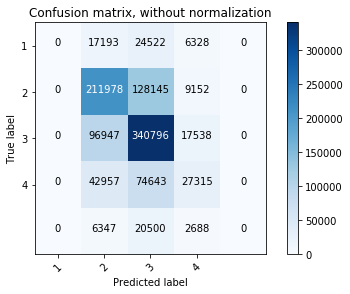

In [36]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, nn_pred2)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4],
                      title='Confusion matrix, without normalization')
plt.savefig('nn_cm_wo_normal.png')
plt.show()

Normalized confusion matrix
[[0.   0.36 0.51 0.13 0.  ]
 [0.   0.61 0.37 0.03 0.  ]
 [0.   0.21 0.75 0.04 0.  ]
 [0.   0.3  0.52 0.19 0.  ]
 [0.   0.21 0.69 0.09 0.  ]]


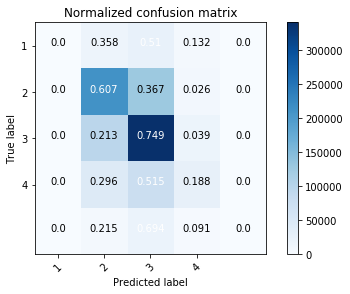

In [37]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4], normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('nn_cm_w_normal.png')
plt.show()